In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def get_data(dataset):
    data = load_svmlight_file("./{}".format(dataset))
    # data = load_svmlight_file("../dataset/australian_scale")
    input_data = data[0].toarray()
    return input_data, data[1]

In [12]:
def initial_w(dimension):
    # w = np.zeros((dimension, 1))
    w = np.random.random((dimension, 1))
    # w = np.random.normal(size=(dimension, 1))
    return w

In [16]:
def plot_test_loss(testing_loss, algorithm, show=False):
    x = np.array(range(1, len(testing_loss)+1))
    plt.figure(0)
    # plt.plot(x, np.array(training_loss), label="train")
    plt.plot(x, np.array(testing_loss), label=algorithm)
    if show==True:
        plt.xlabel("Epoch")
        plt.ylabel("Validation Loss")
        plt.title("Experiment")
        plt.grid(True)
        plt.legend()
        plt.show(show)

In [5]:
def sigmoid(w, X):
    return 1.0/(1.0+np.e**(-np.dot(X, w)))

In [14]:
def main(lr, C, batch_size):
    # get dataset
    # x_train, x_test, y_train, y_test = get_dataset(input_data, label)
    x_train, y_train = get_data('a9a')
    x_test, y_test = get_data('a9a.t')

    # handle data
    temp = np.zeros((len(x_test), 1))
    x_test = np.column_stack((x_test, temp))
    y_train_accuracy = y_train.copy()
    y_test_accuracy = y_test.copy()
    # y_train[y_train==-1] = 0
    # y_test[y_test==-1] = 0

    # handle b
    train_column = np.ones((len(x_train), 1))
    x_train = np.column_stack((x_train, train_column))
    test_column = np.ones((len(x_test), 1))
    x_test = np.column_stack((x_test, test_column))

    algorithm = ['SGD', 'NAG', 'RMSProp', 'Adadelta', 'Adam']
    # algorithm = ['SGD', 'NAG', 'RMSProp', 'Adam']
    # algorithm = ['SGD', 'NAG']
    # algorithm = ['RMSProp']

    for a in range(len(algorithm)):

        # initialize the w
        w = initial_w(dimension=(123+1))

        # plot
        training_loss_list = []
        testing_loss_list = []
        training_accuracy_list = []
        testing_accuracy_list = []

        # number of batch
        num_batch = int(len(x_train)/batch_size + 1)

        # initialize the v(t-1) NAG
        v_t_1 = np.zeros((123+1, 1))
        # initialize the g(t-1) RMSProp
        # g_t_1 = np.zeros((123+1, 1))
        g_t_1 = 0.0
        # initialize the delta(t-1) AdaDelta
        delta_t_1 = np.zeros((123+1, 1))
        # initialize the v(t-1) and m(t-1) Adam
        v_t_1_a = np.zeros((123+1, 1))
        m_t_1 = np.zeros((123+1, 1))

        # # training_accuracy = training_accuracy/num_batch
        # # testing_accuracy = testing_accuracy/num_batch
        # hit = np.dot(x_train, w) * y_train_accuracy.reshape(-1, 1)
        # training_accuracy = float(len(hit[hit>0]))/len(hit)
        # hit = np.dot(x_test, w) * y_test_accuracy.reshape(-1, 1)
        # testing_accuracy = float(len(hit[hit>0]))/len(hit)

        # training_accuracy_list.append(training_accuracy)
        # testing_accuracy_list.append(testing_accuracy)
        # print("training accuracy:[{}] testing accuracy:[{}]".format(training_accuracy, testing_accuracy))


        for i in range(100):
            training_loss = 0.0
            testing_loss = 0.0
            training_accuracy = 0.0
            testing_accuracy = 0.0
            # shuffle each batch in different epochs
            shuffle = random.sample(range(len(x_train)), len(x_train))
            for j in range(num_batch):
                # batch
                if j!=num_batch-1:
                    # the data in each batch
                    x = x_train[shuffle[j*batch_size:(j+1)*batch_size]]
                    y = y_train[shuffle[j*batch_size:(j+1)*batch_size]]
                elif j==num_batch-1:
                    # the data in each batch
                    x = x_train[shuffle[j*batch_size:]]
                    y = y_train[shuffle[j*batch_size:]]

                # the first value for ploting
                if i==0:
                    training_loss_list.append(((1.0/2) * (np.dot(np.transpose(w), w)) + C * np.sum(temp)/len(x_train))[0][0])
                    testing_loss_list.append(((1.0/2) * (np.dot(np.transpose(w), w)) + C * np.sum(temp)/len(x_test))[0][0])
                    # print(((1.0/2) * (np.dot(np.transpose(w), w)) + opt.C * np.sum(temp)/len(x_test))[0][0])
                    # assert False
                    training_accuracy_list.append(training_accuracy)
                    testing_accuracy_list.append(testing_accuracy)

                # algorithm
                if algorithm[a]=="SGD":
                    # calculate the gradient
                    temp = 1 - (y.reshape(-1, 1) * np.dot(x, w))
                    temp[temp<=0] = 0
                    grad = w - C * (np.dot(np.transpose(x), temp * y.reshape(-1, 1)))/len(x)
                    # update
                    w = w - lr * grad

                elif algorithm[a]=="NAG":
                    # calculate the gradient
                    temp = 1 - (y.reshape(-1, 1) * np.dot(x, w-0.9*v_t_1))
                    temp[temp<=0] = 0
                    grad = w - C * (np.dot(np.transpose(x), temp * y.reshape(-1, 1)))/len(x)
                    # # calculate the gradient
                    # grad = (np.dot(np.transpose(x), (sigmoid((w-0.9*v_t_1), x) - y.reshape(-1, 1))))/len(x)
                    v_t = 0.9*v_t_1 + lr * grad
                    # update
                    w = w - v_t
                    v_t_1 = v_t.copy()

                elif algorithm[a]=="Adadelta":
                    # calculate the gradient
                    temp = 1 - (y.reshape(-1, 1) * np.dot(x, w))
                    temp[temp<=0] = 0
                    grad = w - C * (np.dot(np.transpose(x), temp * y.reshape(-1, 1)))/len(x)
                    # grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                    g_t = grad.copy()
                    g_t = 0.1 * np.square(g_t_1) + 0.9 * np.square(g_t)

                    # update
                    # delta_w = (np.sqrt(np.mean(delta_t_1)+0.001)/np.sqrt(np.mean(g_t)+0.001))*grad
                    delta_w = (np.sqrt(np.mean(delta_t_1)+0.001)/np.sqrt(g_t+0.001))*grad
                    w = w - delta_w
                    delta_t = 0.9 * delta_t_1 + 0.1 * np.square(delta_w)
                    delta_t_1 = delta_t.copy()

                elif algorithm[a]=="RMSProp":
                    # calculate the gradient
                    temp = 1 - (y.reshape(-1, 1) * np.dot(x, w))
                    temp[temp<=0] = 0
                    grad = w - C * (np.dot(np.transpose(x), temp * y.reshape(-1, 1)))/len(x)
                    # grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                    # g_t = grad.copy()
                    g_t = 0.001 * np.square(g_t_1) + 0.999 * np.square(grad)
                    # g_t = 0.9 * np.square(g_t_1) + 0.1 * np.square(g_t)

                    # update
                    w = w - (lr*grad)/np.sqrt(g_t+0.001)
                    g_t_1 = g_t.copy()

                elif algorithm[a]=="Adam":
                    # calculate the gradient
                    temp = 1 - (y.reshape(-1, 1) * np.dot(x, w))
                    temp[temp<=0] = 0
                    grad = w - C * (np.dot(np.transpose(x), temp * y.reshape(-1, 1)))/len(x)
                    # grad = (np.dot(np.transpose(x), (sigmoid(w, x) - y.reshape(-1, 1))))/len(x)
                    m_t = 0.9 * m_t_1 + 0.1 * grad
                    v_t_a = 0.999 * v_t_1_a + 0.001 * np.square(grad)
                    m_t_hat = m_t / ( 1 - np.power(0.9, i*num_batch+j+1))
                    v_t_a_hat = v_t_a / ( 1 - np.power(0.999, i*num_batch+j+1))
                    # update
                    w = w - lr * m_t_hat / (np.sqrt(v_t_a_hat) + 1e-8)
                    m_t = m_t_hat
                    v_t_a = v_t_a_hat

                # # training error and testing error
                # training_loss += -np.mean(y_train.reshape(-1, 1) * np.log(sigmoid(w, x_train)) + (1 - y_train.reshape(-1, 1)) * (np.log(1 - sigmoid(w, x_train))))
                # testing_loss += -np.mean(y_test.reshape(-1, 1) * np.log(sigmoid(w, x_test)) + (1 - y_test.reshape(-1, 1)) * (np.log(1 - sigmoid(w, x_test))))
            
                # training error and testing error
                temp = 1 - (y_train.reshape(-1, 1) * np.dot(x_train, w))
                temp[temp<=0] = 0
                training_loss = ((1.0/2) * (np.dot(np.transpose(w), w)) + C * np.sum(temp)/len(x_train))[0][0]
                # training_loss += training_loss.reshape(-1)
                training_loss += training_loss

                temp = 1 - (y_test.reshape(-1, 1) * np.dot(x_test, w))
                temp[temp<=0] = 0
                testing_loss = ((1.0/2) * (np.dot(np.transpose(w), w)) + C * np.sum(temp)/len(x_test))[0][0]
                # testing_loss += testing_loss.reshape(-1)
                testing_loss += testing_loss

                # # training accuracy and testing accuracy
                # hit = np.dot(x_train, w) * y_train.reshape(-1, 1)
                # training_accuracy += float(len(hit[hit>0]))/len(hit)

                # hit = np.dot(x_test, w) * y_test.reshape(-1, 1)
                # testing_accuracy += float(len(hit[hit>0]))/len(hit)


            training_loss = training_loss/num_batch
            testing_loss = testing_loss/num_batch
            training_loss_list.append(training_loss)
            testing_loss_list.append(testing_loss)
            print("training error:[{}] testing error:[{}]".format(training_loss, testing_loss))

            # training_accuracy = training_accuracy/num_batch
            # testing_accuracy = testing_accuracy/num_batch
            hit = np.dot(x_train, w) * y_train_accuracy.reshape(-1, 1)
            training_accuracy = float(len(hit[hit>0]))/len(hit)
            hit = np.dot(x_test, w) * y_test_accuracy.reshape(-1, 1)
            testing_accuracy = float(len(hit[hit>0]))/len(hit)

            training_accuracy_list.append(training_accuracy)
            testing_accuracy_list.append(testing_accuracy)
            print("training accuracy:[{}] testing accuracy:[{}]".format(training_accuracy, testing_accuracy))


        # plot
        # plot_loss(training_loss_list, testing_loss_list)
        if a==len(algorithm)-1:
            plot_test_loss(testing_loss=testing_loss_list, algorithm=algorithm[a], show=True)
            # plot_test_accuracy(testing_accuracy=testing_accuracy_list, algorithm=algorithm[a], show=True)
        else:
            plot_test_loss(testing_loss=testing_loss_list, algorithm=algorithm[a], show=False)
            # plot_test_accuracy(testing_accuracy=testing_accuracy_list, algorithm=algorithm[a], show=False)


training error:[9.060171253949912] testing error:[9.065257234014565]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[8.12019403924234] testing error:[8.124487987750532]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[7.308976703456894] testing error:[7.312590386353471]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[6.605297692615485] testing error:[6.6083338291812055]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[5.989429213698376] testing error:[5.991990664343156]
training accuracy:[0.2408709806209883] testing accuracy:[0.23634911860450833]
training error:[5.44755607007637] testing error:[5.449503876533405]
training accuracy:[0.24274438745738766] testing accuracy:[0.23862170628339782]
training error:[4.969635724434809] testing error:[4.9709202496166585]
training accuracy:[0.24802678050428426] testing 

training error:[0.2634184942357718] testing error:[0.26236238977403376]
training accuracy:[0.7637050459138233] testing accuracy:[0.7680732141760334]
training error:[0.25791480896360497] testing error:[0.2568656033965859]
training accuracy:[0.7634286416264857] testing accuracy:[0.7677046864443215]
training error:[0.25281838769551424] testing error:[0.2517758134951697]
training accuracy:[0.7633672184515218] testing accuracy:[0.7675204225784656]
training error:[0.24819685051564805] testing error:[0.2471621233698686]
training accuracy:[0.7635207763889316] testing accuracy:[0.767459001289847]
training error:[0.24396802179243124] testing error:[0.24294186216291364]
training accuracy:[0.7636743343263414] testing accuracy:[0.7675204225784656]
training error:[0.23999135137311448] testing error:[0.23897130884106904]
training accuracy:[0.7634900648014495] testing accuracy:[0.7675204225784656]
training error:[0.2364118774326757] testing error:[0.2353997548265844]
training accuracy:[0.7632443721015

training error:[0.20740313431637575] testing error:[0.20678196213061256]
training accuracy:[0.7605110408156998] testing accuracy:[0.7654320987654321]
training error:[0.2081980566194371] testing error:[0.20758174263789445]
training accuracy:[0.7655170295752588] testing accuracy:[0.7701615379890671]
training error:[0.2019842187094412] testing error:[0.20124952598978213]
training accuracy:[0.7626301403519548] testing accuracy:[0.7669676309808979]
training error:[0.1951394179907575] testing error:[0.19428212854046115]
training accuracy:[0.7601732133533983] testing accuracy:[0.7650635710337202]
training error:[0.191436027786181] testing error:[0.1905223673827295]
training accuracy:[0.7598660974785787] testing accuracy:[0.7646336220133898]
training error:[0.19109806944536634] testing error:[0.1901956712744698]
training accuracy:[0.7597739627161328] testing accuracy:[0.7644493581475339]
training error:[0.1924802099484305] testing error:[0.1916165867187696]
training accuracy:[0.759773962716132

training error:[0.1932891249934081] testing error:[0.19243837414197362]
training accuracy:[0.7594668468413133] testing accuracy:[0.7639579878385848]
training error:[0.19338888466432502] testing error:[0.19254044250760372]
training accuracy:[0.7594668468413133] testing accuracy:[0.7639579878385848]
training error:[0.19352443816181897] testing error:[0.1926802203211684]
training accuracy:[0.7594668468413133] testing accuracy:[0.7640194091272035]
training error:[0.19389544674760684] testing error:[0.19306041462117537]
training accuracy:[0.7594668468413133] testing accuracy:[0.7640808304158221]
training error:[0.19374044783828992] testing error:[0.1929026161057941]
training accuracy:[0.7594668468413133] testing accuracy:[0.7640808304158221]
training error:[0.19338771276816333] testing error:[0.1925421097502436]
training accuracy:[0.7594668468413133] testing accuracy:[0.7640194091272035]
training error:[0.19333498669481197] testing error:[0.19248855233224504]
training accuracy:[0.7594668468

training error:[0.19251724687284855] testing error:[0.19164876169250178]
training accuracy:[0.7594054236663493] testing accuracy:[0.7639579878385848]
training error:[0.19804161764163203] testing error:[0.19729608962937908]
training accuracy:[0.7601732133533983] testing accuracy:[0.7646950433020084]
training error:[0.1935194052352407] testing error:[0.1926741060340772]
training accuracy:[0.7594668468413133] testing accuracy:[0.7640194091272035]
training error:[0.1945507075084029] testing error:[0.1937293512347594]
training accuracy:[0.7594361352538312] testing accuracy:[0.7640808304158221]
training error:[0.19310523830233262] testing error:[0.19226592831829653]
training accuracy:[0.7594361352538312] testing accuracy:[0.7640194091272035]
training error:[0.1920698301228883] testing error:[0.1912013314643273]
training accuracy:[0.7594361352538312] testing accuracy:[0.7639579878385848]
training error:[0.19412485191170153] testing error:[0.19329189450392326]
training accuracy:[0.759466846841

training error:[0.19402805145788204] testing error:[0.19319398059386655]
training accuracy:[0.7594361352538312] testing accuracy:[0.7641422517044407]
training error:[0.19524523556105183] testing error:[0.19442220248538103]
training accuracy:[0.7594668468413133] testing accuracy:[0.7642036729930594]
training error:[0.19294091775805752] testing error:[0.19207353628044785]
training accuracy:[0.7594361352538312] testing accuracy:[0.7640194091272035]
training error:[0.1935568446375068] testing error:[0.19270376797143457]
training accuracy:[0.7594361352538312] testing accuracy:[0.7639579878385848]
training error:[0.1910868491830386] testing error:[0.19019231801353334]
training accuracy:[0.7593132889039035] testing accuracy:[0.7638965665499662]
training error:[0.19106693996364849] testing error:[0.19016952485906735]
training accuracy:[0.7593440004913854] testing accuracy:[0.7639579878385848]
training error:[0.19475756254897103] testing error:[0.19393924294116519]
training accuracy:[0.75943613

training error:[0.17266705340612476] testing error:[0.17132565036182162]
training accuracy:[0.7591904425539756] testing accuracy:[0.7637737239727289]
training error:[0.17334020904987457] testing error:[0.1720322177273957]
training accuracy:[0.7591904425539756] testing accuracy:[0.7637737239727289]
training error:[0.1733586781547702] testing error:[0.17204756160456575]
training accuracy:[0.7591904425539756] testing accuracy:[0.7637737239727289]
training error:[0.1733850696144575] testing error:[0.1720686215254735]
training accuracy:[0.7591904425539756] testing accuracy:[0.7637737239727289]
training error:[0.17341142677348576] testing error:[0.17209330723257768]
training accuracy:[0.7591904425539756] testing accuracy:[0.7637737239727289]
training error:[0.17303474066400565] testing error:[0.1717058202714539]
training accuracy:[0.7591904425539756] testing accuracy:[0.7637737239727289]
training error:[0.17332809185466086] testing error:[0.172008722842236]
training accuracy:[0.7591904425539

training error:[9.493418615281145] testing error:[9.503261639037317]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[8.949151846466256] testing error:[8.958695560325447]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[8.411719649235852] testing error:[8.420959894537773]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[7.875521203574564] testing error:[7.884449244677403]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[7.340663105713934] testing error:[7.349256636335494]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[6.804807312550687] testing error:[6.813040520023323]
training accuracy:[0.2408095574460244] testing accuracy:[0.23622627602727106]
training error:[6.275282484163132] testing error:[6.283139880718086]
training accuracy:[0.2408095574460244] testing ac

training error:[0.20469997942077564] testing error:[0.2040954931616661]
training accuracy:[0.7635821995638955] testing accuracy:[0.7681960567532706]
training error:[0.2047257078536629] testing error:[0.20416245414056214]
training accuracy:[0.7657320106876324] testing accuracy:[0.7699772741232112]
training error:[0.2055136970976439] testing error:[0.2049250211120116]
training accuracy:[0.7660084149749701] testing accuracy:[0.7701615379890671]
training error:[0.20585656869374913] testing error:[0.20528263356985788]
training accuracy:[0.7666840698995732] testing accuracy:[0.771021436029728]
training error:[0.20547624441827397] testing error:[0.2049309709376624]
training accuracy:[0.766776204662019] testing accuracy:[0.770837172163872]
training error:[0.20558567593898486] testing error:[0.20500195383890318]
training accuracy:[0.7664383771997174] testing accuracy:[0.770345801854923]
training error:[0.20568029460873583] testing error:[0.20509807757412601]
training accuracy:[0.766469088787199

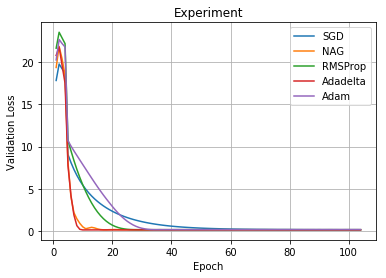

In [17]:
if __name__ == '__main__':
    lr = 0.01
    C = 2**-1
    batch_size = 10000
    main(lr=lr, C=C, batch_size=batch_size)